FIUFIP: Que No Se Escape Nadie

## Introducción

Este trabajo consiste en analizar una serie de datos recoletados por la agencia gubernamental de recaudación de impuestos *FIUFIP*.

Buscaremos entender como se relacionan estos datos y determinar un metodo de si una persona tiene **altos ingresos** o **bajos ingresos** a partir de los datos recibidos, que consisten en una serie de atributos de la persona que la agencia fue llenando y catalogando a la persona como de altos ingresos o no.



## Objetivos

**Tarea**: explicar qué conclusiones se pueden llegar a partir de analizar los datos recolectados

* Saber cómo entender cada uno de los datos
* Saber cómo se relacionan entre sí 
* Saber si se puede sacar alguna conclusión o descubrir un patrón a partir de estos

**Adicionalmente**

* Saber cuáles son los factores más importantes que determinan si un usuario **tiene altos** o **bajos ingresos** {*varible_target*}.

**Baseline**: código simple 

* intente predecir el target (si el usuario tiene **altos ingresos** o **bajos ingresos**).




## Carga de librerias y dataset

In [45]:
from collections import Counter # se usará? la saqué del notebook "pandas introduccion"
import requests # se usará? la saqué del notebook "pandas introduccion"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from matplotlib import pyplot as plt
from pandas_profiling import ProfileReport

from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)

Tambien leemos el dataset, que está en formato CSV desde Google Drive.

In [46]:
with requests.get(
    "https://docs.google.com/spreadsheets/d/1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0/export?format=csv"
) as r, open("fiufip_dataset.csv", "wb") as f:
    for chunk in r.iter_content():
        f.write(chunk)
        import pandas as pd


In [47]:
df = pd.read_csv("fiufip_dataset.csv")

# Verificando la "calidad" de los datos


Previo a buscar relaciones entre los datos provistos, verifiquemos faltantes, su distribución y solucionemos problemas que puedan aparecer

## ¿Que cantidad de valores nulos o inválidos hay en el dataset provisto?

Por ser una base de datos de la agencia FIUFIP, es posible que algunos contribuyentes hayan decido no responder o responder erroneamente a la hora de exponer sus datos personales

En primer lugar, veamos si hay datos faltantes

In [48]:
df.isnull().sum()

anios_estudiados                                 0
barrio                                         583
categoria_de_trabajo                          1836
edad                                             0
educacion_alcanzada                              0
estado_marital                                   0
ganancia_perdida_declarada_bolsa_argentina       0
genero                                           0
horas_trabajo_registradas                        0
religion                                         0
rol_familiar_registrado                          0
tiene_alto_valor_adquisitivo                     0
trabajo                                       1843
dtype: int64

Se pueden observar todas las features provistas. En particular solo tres de ellas presentan valores nulos. Veamos en primer lugar que sucede con la feature barrio

### ¿Qué sucede y cómo se distribuye la feature barrio?

Veamos las cantidad de opciones y sus posibilidades

In [49]:
len(df.barrio.value_counts().index)


41

In [50]:
df.barrio.value_counts(dropna=False,sort=True)

Palermo                29170
Belgrano                 643
NaN                      583
San Isidro               198
Villa Urquiza            137
Recoleta                 121
La Boca                  114
Agronomia                106
Almagro                  100
Balvanera                 95
Puerto Madero             90
Caballito                 81
Boedo                     80
Barracas                  75
Chacarita                 73
Coghland                  70
Floresta                  67
Constitucion              64
Colegiales                62
Flores                    60
Liniers                   59
Monte Castro              51
Mataderos                 44
Nueva Pompeya             43
Monserrat                 37
nuñez                     34
Parque Chacabuco          31
Villa Luro                29
Parque Avellaneda         29
Parque Chas               28
La Paternal               24
Retiro                    20
Villa Soldati             19
Villa Devoto              19
Villa Real    

Lo primero a destacar es que hay 41 barrios mientrás que Capital Federal tiene 48, luego los datos faltantes podrían deberse a que no estaban todas las opciones disponibles. Cambiemos el Nan por 'Otro'. Luego, resulta llamativo la cantidad de instancias de 'Palermo', veamos en un gráfico la proporción de cada opción respecto del total

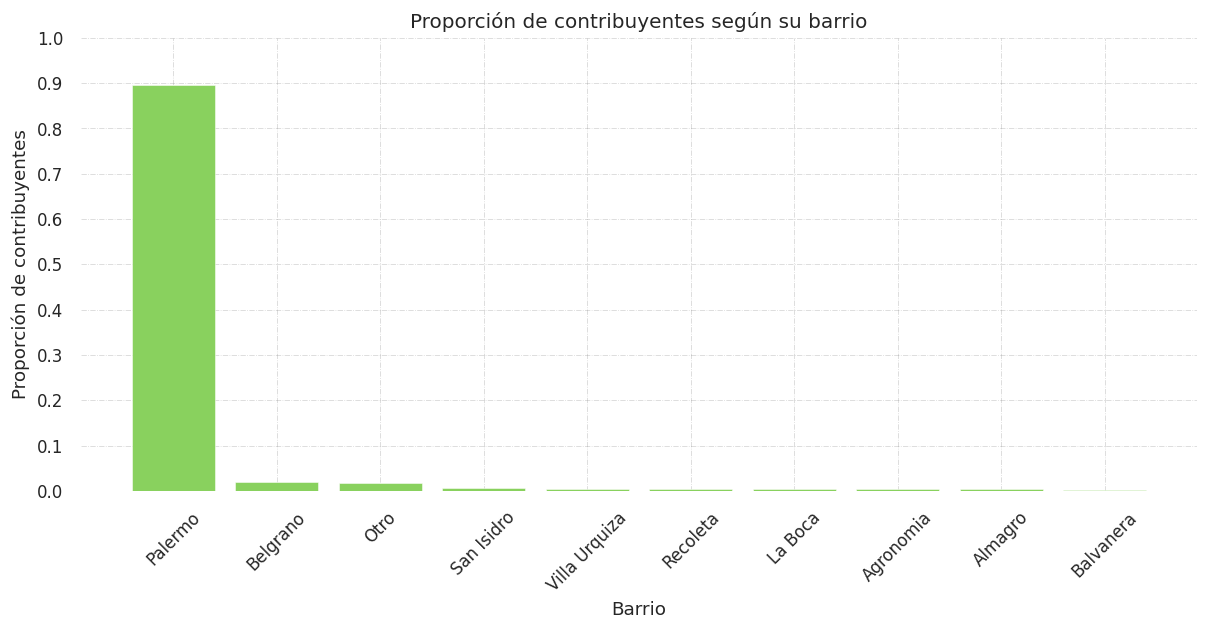

In [51]:
df['barrio'] = df['barrio'].replace(np.nan,'Otro')

cantidad_barrios_visualizados = 10

plt.figure(dpi=120,figsize =(12, 5))
barrios = (
    df['barrio']
    .value_counts(normalize=True)
    .sort_values(ascending=False)
)
ax = plt.bar(barrios.iloc[:cantidad_barrios_visualizados].index, barrios.iloc[:cantidad_barrios_visualizados].values, color = '#89D15E')

plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)

plt.ylabel("Proporción de contribuyentes")
plt.xlabel("Barrio")
plt.title("Proporción de contribuyentes según su barrio")
plt.xticks(rotation=45)
plt.yticks(np.arange(0,1.1, 0.1))
plt.show()


Palermo          29170
Belgrano           643
Otro               583
San Isidro         198
Villa Urquiza      137
Recoleta           121
La Boca            114
Agronomia          106
Almagro            100
Balvanera           95
Name: barrio, dtype: int64

[]

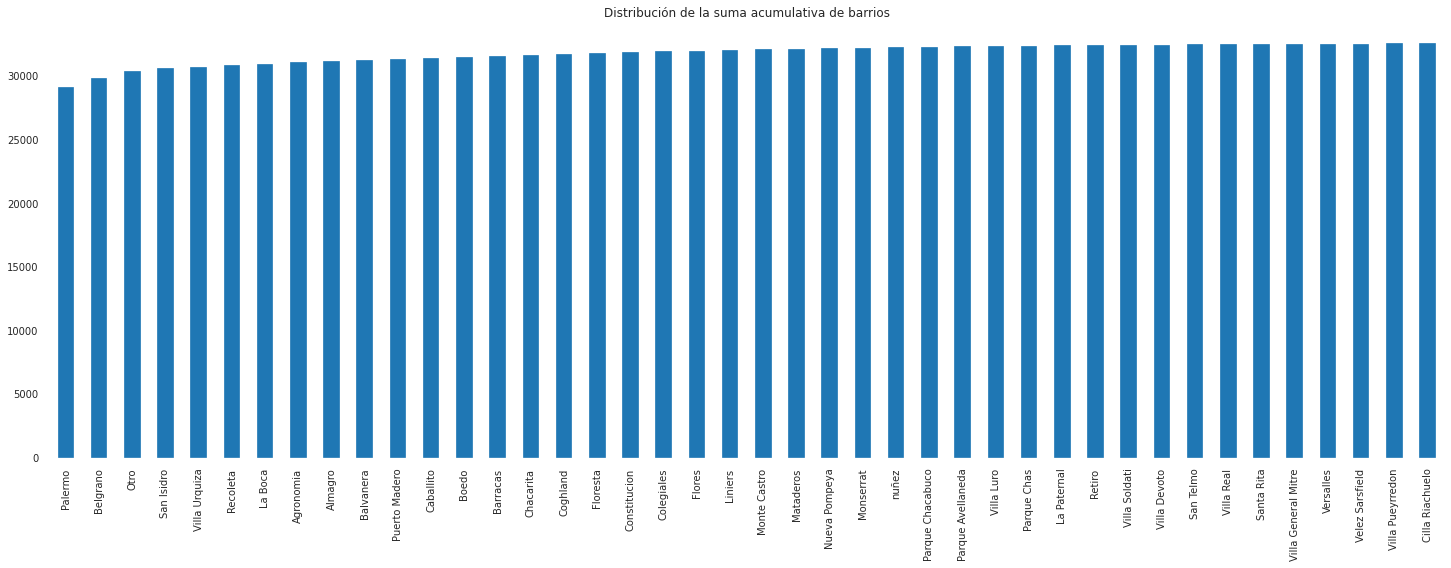

In [52]:
barrios_unicos = df['barrio'].value_counts(dropna=False)
display(barrios_unicos.head(10))
barrios_unicos.cumsum().plot(
    kind='bar', title="Distribución de la suma acumulativa de barrios", figsize=(25, 8)
)
plt.plot()

De este gráfico, podemos observar que casi el 90% de los contribuyentes vive en el barrio de Palermo. **Aca habria que decir que descartamos encontrar alguna relación porque casi todos estan en Palermo, pero no se como decirlo. También calculo que podriamos dejar uno solo, a mi me gusta mas el segundo** 

### ¿Qué sucede con los valores nulos en feature 'categoría de trabajo' y 'trabajo'?

Lo primero que se observa es que los faltantes de una y otra categoria son similares

In [53]:
df.trabajo.value_counts()

profesional_especializado    4140
reparador                    4099
directivo_gerente            4066
entretenimiento              3770
ventas                       3650
otros                        3295
inspector                    2002
transporte                   1597
limpiador                    1370
sector_primario               994
soporte_tecnico               928
seguridad                     649
servicio_domestico            149
ejercito                        9
Name: trabajo, dtype: int64

In [72]:
df['trabajo'] = df['trabajo'].replace(np.nan,'No contesta')
df['categoria_de_trabajo'] = df['categoria_de_trabajo'].replace(np.nan,'No contesta')

tabla_pivot = pd.pivot_table(df,values='edad',index='trabajo',columns='categoria_de_trabajo',aggfunc='count').sort_index()
tabla_pivot

categoria_de_trabajo,No contesta,empleadao_estatal,empleado_municipal,empleado_provincial,monotibutista,relacion_de_dependencia,responsable_inscripto,sin_trabajo,trabajo_voluntariado
trabajo,,,,,,,,,
No contesta,1836.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN
directivo_gerente,NaN,180.0,214.0,189.0,392.0,2691.0,400.0,NaN,NaN
ejercito,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
entretenimiento,NaN,317.0,283.0,253.0,50.0,2833.0,31.0,NaN,3.0
inspector,NaN,14.0,12.0,13.0,36.0,1913.0,13.0,NaN,1.0
limpiador,NaN,23.0,47.0,9.0,15.0,1273.0,2.0,NaN,1.0
otros,NaN,35.0,193.0,124.0,175.0,2740.0,27.0,NaN,1.0
profesional_especializado,NaN,175.0,705.0,414.0,373.0,2313.0,160.0,NaN,NaN
reparador,NaN,64.0,146.0,56.0,531.0,3195.0,106.0,NaN,1.0


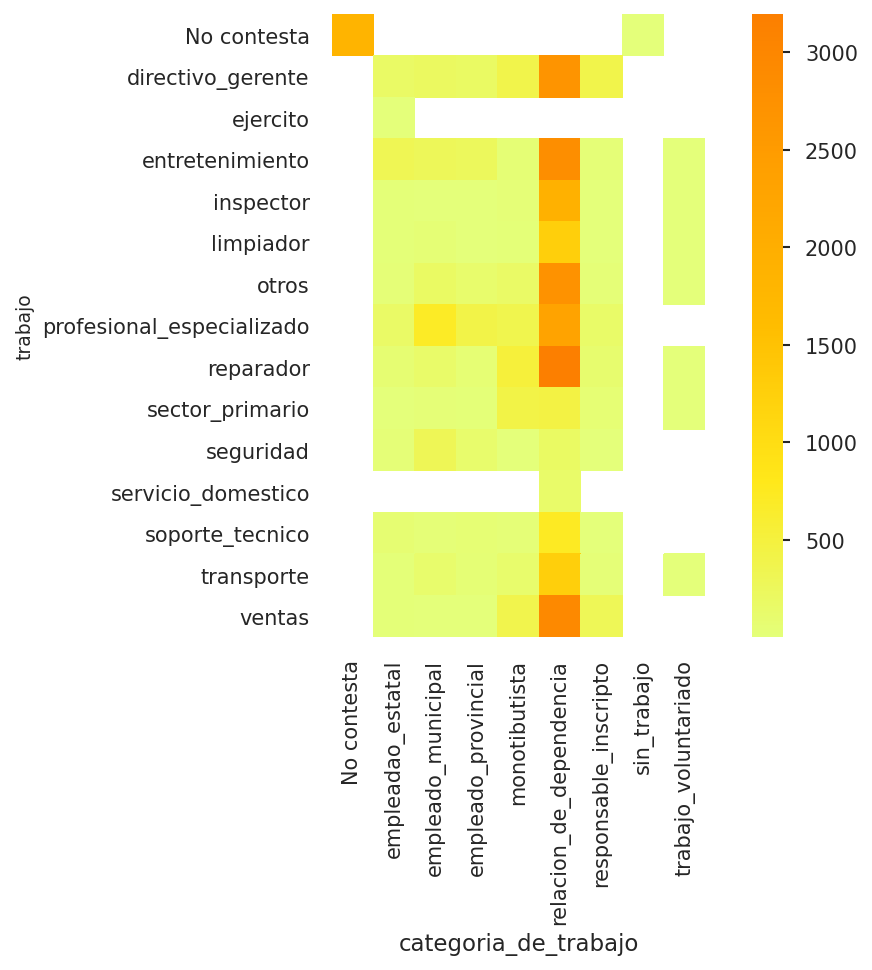

In [73]:
plt.figure(dpi=150)
plt.ylabel("Trabajo", fontsize=9)
sns.heatmap(tabla_pivot, square=True, cmap="Wistia")
plt.show()

**Mi idea aca era hacer un heatmap, que muestre que la cantidad de gente que no contesto a categoria_trabajo es casi igual a la que no contesto trabajo, el proyecto no prospero. Tuve mas que nada problemas en la pivot table. Igual se visualiza lo que te digo si te fijas y se podrian poner algunas conclusiones adicionales**

** Hasta aca llegue, para mi habria que seguir verificando los valores numericos y que sean correctos, y luego si hay alguna feature en particular que valga la pena resaltar algo, como con los barrios (podemos revisar el profiling para ver si hay alguna idea). Otra cosa que falto es chequear valores falopa (esta en el otro notebook) y remplazarlo por nulos. Intente ir "contando" una historia para justificar cada cosa que me iba fijando. Lo mas complicado es claramente graficar, centremosnos en eso. Aca ya medio que veo la correlacion de dos variables, no lo veo mal porque conecta bien con fijarse por los nulos. **